Compute MNE inverse solution on evoked data with a volume source space

In [3]:
%matplotlib inline

In [7]:
import os.path as op
import matplotlib.pyplot as plt

from nilearn import plotting

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse

In [19]:
# Set dir
data_path = mne.datasets.sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_mixed_src = op.join(bem_dir, '%s-oct-6-mixed-src.fif' % subject) # where to save source space as .fif file
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz') # where is the brain seg file

fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject) # where is the bem (with only inner skull)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject) # where is the bem (whole model)

fname_evoked = data_dir + '/sample_audvis-ave.fif' # where is the evoked data
fname_trans = data_dir + '/sample_audvis_raw-trans.fif' # where is the MRI transform file
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'# 
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

In [20]:
# create a volume-based source space 
# based on the aseg file and bem with onlu inner skull
src = mne.setup_volume_source_space(
    subject, mri=fname_aseg, pos=10.0, bem=fname_model, 
    subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=False)

# visualize the source space
# src.plot(subjects_dir=subjects_dir)

# save the source space
# mne.write_source_spaces(fname_mixed_src, src, overwrite=True)

In [22]:
# calculate fwd matrix 
# depending on data, transformation, source_space, whole bem 
fwd = mne.make_forward_solution(
    fname_evoked, fname_trans, src, fname_bem,
    mindist=5.0,  # ignore sources<=5mm from innerskull
    meg=True, eeg=False, n_jobs=1)

# del src

Source space          : <SourceSpaces: [<volume, shape=(15, 18, 17), n_used=1306>] MRI (surface RAS) coords, subject 'sample', ~702 kB>
MRI -> head transform : C:\Users\WillKD\mne_data\MNE-sample-data\MEG\sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis-ave.fif
Conductor model   : C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 1306 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -

In [24]:
# Load data
condition = 'Left Auditory'
evoked = mne.read_evokeds(fname_evoked, condition=condition,
                          baseline=(None, 0))
noise_cov = mne.read_cov(fname_cov)

Reading C:\Users\WillKD\mne_data\MNE-sample-data\MEG\sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
    365 x 365 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 59) active


In [31]:
# get inverse_operator
# depending on fwd matrix, noise conv
loose = dict(volume=1.)
inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, depth=None, loose=loose, verbose=False)

# del fwd

In [41]:
# solve
snr = 3.0            # use smaller SNR for raw data
inv_method = 'dSPM'  # sLORETA, MNE, dSPM
parc = 'aparc'       # the parcellation to use, e.g., 'aparc' 'aparc.a2009s'
lambda2 = 1.0 / snr ** 2

stc = apply_inverse(evoked, inverse_operator, lambda2, inv_method)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Left Auditory"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  59.3% variance
    Combining the current components...
    dSPM...
[done]


Fixing initial time: 0.1 sec
Showing: t = 0.100 s, (-45.3, -11.0, 2.7) mm, [3, 7, 8] vox, 2268 vertex
Using control points [ 3.28682625  3.76441167 13.37321294]


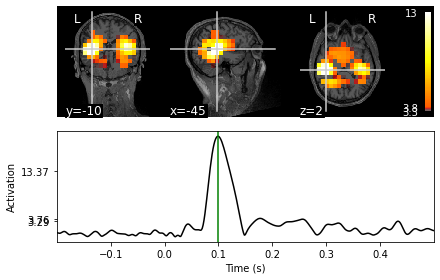

In [42]:
# visualize the result
brain = stc.plot(
    src=inverse_operator['src'], 
    initial_time=initial_time, subjects_dir=subjects_dir)